In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [1]:
WPI_xdf_path = "HCILab1-Group3.xdf"
CSL_xdf_path = "CSL_08_10.xdf"

### View XDF Streams

In [3]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        print(f'Stream {stream_name}')

In [4]:
view_xdf_streams(WPI_xdf_path)

Stream 3: Calculated effective sampling rate 15.2534 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-08T09:44:17-0400']})}
Stream OBS_HCILab1
Stream Unicorn_HCILab1
Stream Unicorn_HCILab2
Stream OBS_HCILab2
Stream Unicorn_CSL_LabPC
Stream OBS_CSL_LabPC
Stream OBS_CSL_Laptop


In [5]:
view_xdf_streams(CSL_xdf_path)

Stream 7: Calculated effective sampling rate -0.5664 Hz is different from specified rate 30.0000 Hz.
Stream 8: Calculated effective sampling rate -45.3639 Hz is different from specified rate 250.0000 Hz.
Stream 4: Calculated effective sampling rate -43.3404 Hz is different from specified rate 250.0000 Hz.
Stream 6: Calculated effective sampling rate -0.1575 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-08T15:45:03+0200']})}
Stream OBS_CSL_Laptop
Stream Unicorn_CSL_Laptop
Stream Unicorn_CSL_LabPC
Stream OBS_CSL_LabPC
Stream OBS_HCILab1
Stream Unicorn_HCILab1
Stream Unicorn_HCILab2
Stream OBS_HCILab2


In [230]:
def view_stream_keys(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    # Print all keys in the stream to inspect the structure
    print(f"Keys in a stream:")
    for key in data[0].keys():
        print(f"- {key}")

view_stream_keys(WPI_xdf_path)

Stream 2: Calculated effective sampling rate 16.8061 Hz is different from specified rate 30.0000 Hz.


Keys in a stream:
- info
- footer
- time_series
- time_stamps
- clock_times
- clock_values


From running the code above, we get that each stream contains:

- info
- footer
- time_series (contains UNIX time stampes for OBS streams)
- time_stamps (contain Lab Recorder time stamps)
- clock_times
- clock_values

Also, from examining the streams of both WPI HCI Lab and CSL xdf files, we get that:

The WPI HCI Lab Stream Names:

- Stream OBS_HCILab1
- Stream Unicorn_HCILab1 (shared)
- Stream OBS_HCILab2 (shared)
- Stream Unicorn_HCILab2
- Stream Unicorn_CSL_LabPC
- Stream OBS_CSL_Laptop

The CSL Lab Stream Names:

- Stream OBS_CSL_Laptop
- Stream Unicorn_CSL_Laptop
- Stream Unicorn_CSL_LabPC
- Stream OBS_CSL_LabPC
- Stream OBS_HCILab2 (shared)
- Stream Unicorn_HCILab1 (shared)

We see that both lab xdf files share OBS_HCILab2 and Unicorn_HCILab1! So, since the same OBS stream is in multiple files, below, I will find the index of the where the UNIX timestamp at the start of the later recording also occurs in the earlier ones. Once I get the LabRecorder timestamp at this index, I will cut all the EEG data with timestamps lower than this value to sync all streams.

Note: the shared streams and streams are only examples from Group 1.

In [330]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

WPI HCI Lab Streams:


Stream 1: Calculated effective sampling rate 15.7510 Hz is different from specified rate 30.0000 Hz.


Stream Unicorn_HCILab1 has 1008116 time stamps, starting with 611253.3354233088
Stream OBS_HCILab1 has 120823 time stamps, starting with 611253.3782084001
Stream OBS_HCILab1 with time series (UNIX) begins with 1731076466.614
Stream OBS_HCILab2 has 21272 time stamps, starting with 611198.701273934
Stream OBS_HCILab2 with time series (UNIX) begins with 1731076466.789
Stream Unicorn_HCILab2 has 301187 time stamps, starting with 611240.2445216796
Stream OBS_CSL_LabPC has 235769 time stamps, starting with 611253.5281848038
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1731076466.921
Stream Unicorn_CSL_LabPC has 975999 time stamps, starting with 611247.0746992254
Stream OBS_CSL_Laptop has 118827 time stamps, starting with 611253.537911259
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1731076469.039

CSL Lab Streams:
Stream OBS_CSL_LabPC has 241375 time stamps, starting with 965124.963829166
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1731076440.921
Stream 

### Investigate any weird stream

In [6]:
# weird streams for Group 3!! 

# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

# Get the starting Unix time of OBS_CSL_Laptop
potential_starting_unix_time = CSL_data_streams[0]["time_series"][0][0]
print(f"Potential starting Unix time for OBS_CSL_Laptop: {potential_starting_unix_time}")

# Get the first potential time stamp for OBS_HCILab2
potential_HCILab2_time_stamp_start = WPI_data_streams[2]["time_stamps"][0]

# Find the index of the time stamp of OBS_HCILab2 that is closest to the potential_HCILab2_time_stamp_start
index = np.searchsorted(WPI_data_streams[3]["time_stamps"], potential_HCILab2_time_stamp_start)

OBS_HCILab2_true_unix_start = WPI_data_streams[3]["time_series"][index][0]
print(f"True Unix start time for OBS_HCILab2: {OBS_HCILab2_true_unix_start}")

Stream 3: Calculated effective sampling rate 15.2534 Hz is different from specified rate 30.0000 Hz.
Stream 7: Calculated effective sampling rate -0.5664 Hz is different from specified rate 30.0000 Hz.
Stream 8: Calculated effective sampling rate -45.3639 Hz is different from specified rate 250.0000 Hz.
Stream 4: Calculated effective sampling rate -43.3404 Hz is different from specified rate 250.0000 Hz.
Stream 6: Calculated effective sampling rate -0.1575 Hz is different from specified rate 30.0000 Hz.


Potential starting Unix time for OBS_CSL_Laptop: 1728395103.777
True Unix start time for OBS_HCILab2: 1728395167.307


### Sync Streams!!

In [7]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # Find the stream with the latest starting Unix timestamp
    latest_unix_timestamp = 0
    latest_OBS_stream = None
    
    for stream_name, stream in streams.items():
        if stream_name.startswith("OBS"):  # OBS streams have the Unix timestamps
            unix_timestamp = stream["time_series"][0][0]
            
            if unix_timestamp > latest_unix_timestamp:
                latest_unix_timestamp = unix_timestamp
                latest_OBS_stream = stream
    
    latest_OBS_stream = streams["OBS_HCILab2"]  # only for Group 3 and 6
    latest_unix_timestamp = latest_OBS_stream["time_series"][0][0]  # only for Group 3 and 6
    
    # Consider the case where the corresponding EEG stream's LabRecorder timestamp is later than the OBS stream's LabRecorder timestamp
    
    # Find the corresponding EEG stream
    corresponding_EEG_stream_name = "Unicorn" + latest_OBS_stream["info"]["name"][0][3:]
    corresponding_EEG_stream = streams[corresponding_EEG_stream_name]
    
    if corresponding_EEG_stream["time_stamps"][0] > latest_OBS_stream["time_stamps"][0]:
        # The EEG stream's LabRecorder timestamp is later than the OBS stream's LabRecorder timestamp
        print("cutting stream based on EEG!")
        
        # Find the index in the OBS stream where the EEG stream's start timestamp occurs
        index_in_OBS = np.searchsorted(latest_OBS_stream["time_stamps"], corresponding_EEG_stream["time_stamps"][0])
        
        # Update the latest Unix timestamp
        latest_unix_timestamp = latest_OBS_stream["time_series"][index_in_OBS][0]
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop"), ("OBS_CSL_LabPC", "Unicorn_CSL_LabPC")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the latest Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        index_in_OBS = np.searchsorted(OBS_unix_times, latest_unix_timestamp)
        
        if index_in_OBS < len(OBS_stream["time_stamps"]):
            labrecorder_timestamp = OBS_stream["time_stamps"][index_in_OBS]
        else:
            labrecorder_timestamp = OBS_stream["time_stamps"][-1]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        index_in_EEG = np.searchsorted(EEG_stream["time_stamps"], labrecorder_timestamp)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][index_in_OBS:]
        OBS_stream["time_series"] = OBS_stream["time_series"][index_in_OBS:]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][index_in_EEG:]
        EEG_stream["time_series"] = EEG_stream["time_series"][index_in_EEG:]
    
    return streams


In [8]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 3: Calculated effective sampling rate 15.2534 Hz is different from specified rate 30.0000 Hz.
Stream 7: Calculated effective sampling rate -0.5664 Hz is different from specified rate 30.0000 Hz.
Stream 8: Calculated effective sampling rate -45.3639 Hz is different from specified rate 250.0000 Hz.
Stream 4: Calculated effective sampling rate -43.3404 Hz is different from specified rate 250.0000 Hz.
Stream 6: Calculated effective sampling rate -0.1575 Hz is different from specified rate 30.0000 Hz.


In [9]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Starting time stamps: {stream["time_stamps"][0]} ...')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Starting time series (UNIX): {stream["time_series"][0][0]} ...')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream OBS_HCILab1 has 129238 time stamps and 129238 time series
Starting time stamps: 3462.45867950733 ...
Starting time series (UNIX): 1728395057.448 ...

Stream Unicorn_HCILab1 has 1077105 time stamps and 1077105 time series
Starting time stamps: 3462.017625534818 ...

Stream Unicorn_HCILab2 has 1016073 time stamps and 1016073 time series
Starting time stamps: 3448.975096914815 ...

Stream OBS_HCILab2 has 66925 time stamps and 66925 time series
Starting time stamps: 3281.9091616267597 ...
Starting time series (UNIX): 1728395082.141 ...

Stream Unicorn_CSL_LabPC has 1052029 time stamps and 1052029 time series
Starting time stamps: 3463.273707990593 ...

Stream OBS_CSL_LabPC has 258465 time stamps and 258465 time series
Starting time stamps: 3462.5905788998753 ...
Starting time series (UNIX): 1728395057.879 ...

Stream OBS_CSL_Laptop has 129231 time stamps and 129231 time series
Starting time stamps: 3462.6118905693484 ...
Starting time series (UNI

In [10]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

cutting stream based on EEG!


In [11]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream OBS_HCILab1 has 125942 time stamps and 125942 time series
Starting time stamps: 3572.325345196059 ...
Starting time series (UNIX): 1728395167.315 ...

Stream Unicorn_HCILab1 has 1049527 time stamps and 1049527 time series
Starting time stamps: 3572.3254451168355 ...

Stream Unicorn_HCILab2 has 1016061 time stamps and 1016061 time series
Starting time stamps: 3449.024109620524 ...

Stream OBS_HCILab2 has 64376 time stamps and 64376 time series
Starting time stamps: 3449.0211046612853 ...
Starting time series (UNIX): 1728395167.307 ...

Stream Unicorn_CSL_LabPC has 1052029 time stamps and 1052029 time series
Starting time stamps: 3463.273707990593 ...

Stream OBS_CSL_LabPC has 258465 time stamps and 258465 time series
Starting time stamps: 3462.5905788998753 ...
Starting time series (UNIX): 1728395057.879 ...

Stream OBS_CSL_Laptop has 129231 time stamps and 129231 time series
Starting time stamps: 3462.6118905693484 ...
Starting time series (UN

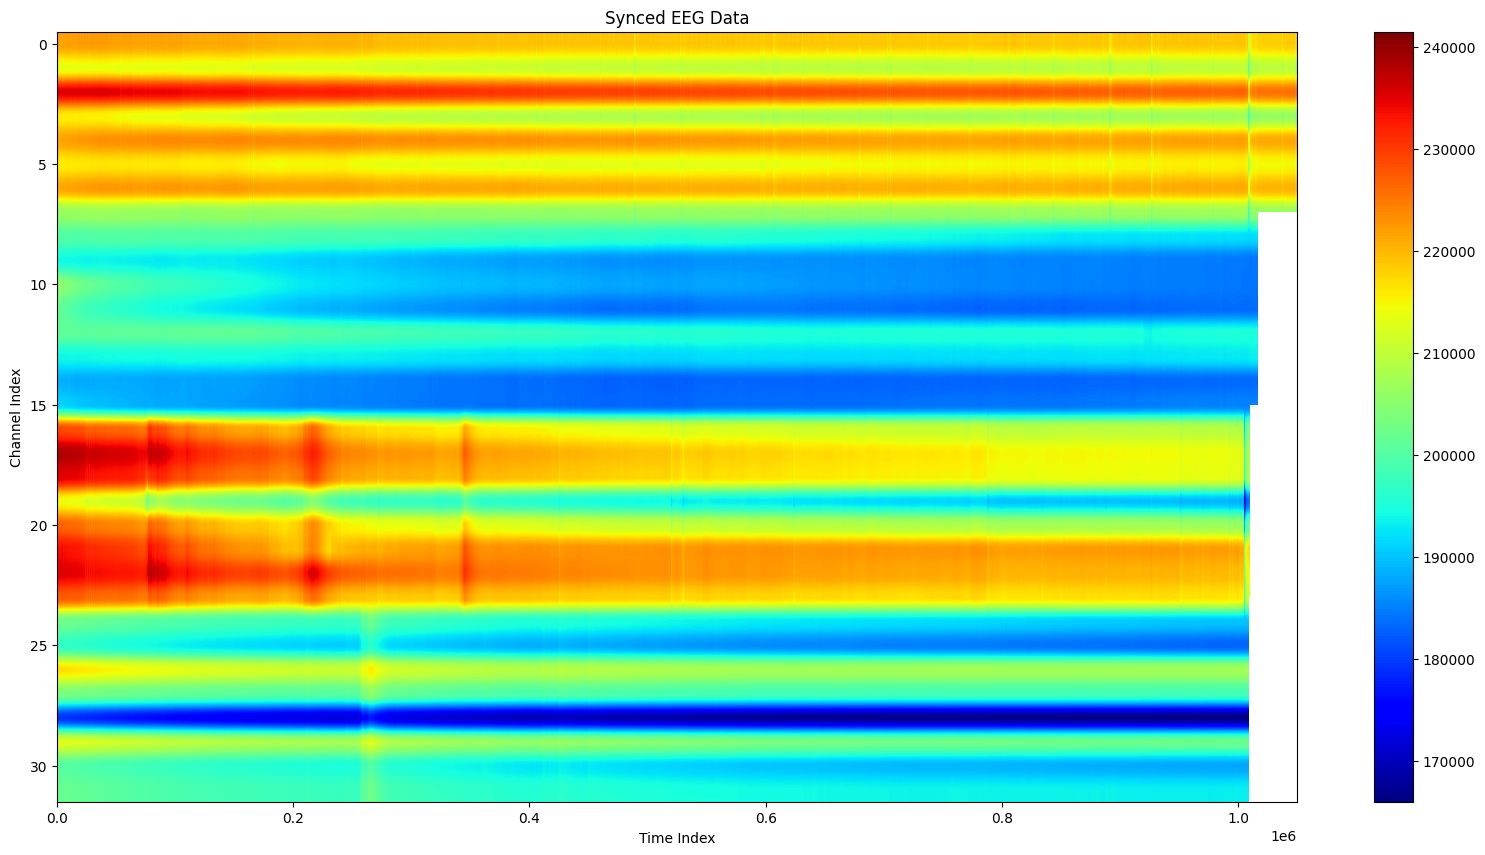

In [12]:
import scipy.io

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 4 * 8)
synced_EEG_data = np.full((max_length, 4 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

# Download the EEG data as an .mat file
# scipy.io.savemat('synced_EEG_data_3.mat', {'synced_EEG_data_3': synced_EEG_data})